This notebook mirrors content in LightningAI's Course on NLP 

In [1]:
import os 
import numpy as np 
import pandas as pd 
import torch
from sklearn.feature_extraction.text import CountVectorizer
from lightning.pytorch.loggers import CSVLogger

from local_dataset_utilities import download_dataset, load_dataset_into_to_dataframe, partition_dataset, IMDBDataset
from local_utilities import LightningModel

/home/aryaman.pandya/ml_accel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_dataset_into_to_dataframe()

100%|██████████| 50000/50000 [00:49<00:00, 1002.74it/s]

Class distribution:


In [3]:
df.columns 

Index(['text', 'label'], dtype='object')

In [4]:
df

,text,label
0,I went and saw this movie last night after bei...,1
0,Actor turned director Bill Paxton follows up h...,1
0,As a recreational golfer with some knowledge o...,1
0,"I saw this film in a sneak preview, and it is ...",1
0,Bill Paxton has taken the true story of the 19...,1
...,...,...
0,"Towards the end of the movie, I felt it was to...",0
0,This is the kind of movie that my enemies cont...,0
0,I saw 'Descent' last night at the Stockholm Fi...,0
0,Some films that you pick up for a pound turn o...,0


In [5]:
partition_dataset(df)

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_val = pd.read_csv('val.csv')

In [7]:
np.bincount(df_train['label'])

array([17452, 17548])

In [8]:
np.bincount(df_test['label'])

array([5006, 4994])

In [9]:
np.bincount(df_val['label'])

array([2542, 2458])

In [10]:
#max features limited to avoid overfitting 
#lower case to disallow duplication of words with different capitalization 
#Stop words clear words like pronouns articles etc. 
count_vec = CountVectorizer(lowercase=True, max_features=10000, stop_words="english")
count_vec.fit(df_train['text'])

CountVectorizer(max_features=10000, stop_words='english')

The above builds a dictionary with the 10,000 most frequent words in the dataset and maps them to their respective counts 

In [ ]:
count_vec.vocabulary_

The following code transforms these datasets into feature vectors

In [12]:
x_train = count_vec.transform(df_train['text'])
x_test = count_vec.transform(df_test['text'])
x_val = count_vec.transform(df_val['text'])

In [13]:
print(x_train)

  (0, 188)	1
  (0, 892)	1
  (0, 915)	1
  (0, 1144)	1
  (0, 1151)	6
  (0, 1320)	1
  (0, 1544)	1
  (0, 1656)	2
  (0, 1816)	1
  (0, 1818)	1
  (0, 1874)	1
  (0, 2574)	1
  (0, 2754)	1
  (0, 2831)	1
  (0, 2910)	1
  (0, 3046)	1
  (0, 3074)	1
  (0, 3076)	1
  (0, 3112)	1
  (0, 3140)	1
  (0, 3141)	1
  (0, 3276)	1
  (0, 3280)	1
  (0, 3371)	1
  (0, 3386)	1
  :	:
  (34999, 8078)	1
  (34999, 8109)	1
  (34999, 8185)	1
  (34999, 8225)	1
  (34999, 8350)	1
  (34999, 8355)	1
  (34999, 8439)	1
  (34999, 8469)	1
  (34999, 8551)	1
  (34999, 8651)	1
  (34999, 8791)	1
  (34999, 9094)	2
  (34999, 9101)	2
  (34999, 9104)	1
  (34999, 9276)	1
  (34999, 9490)	1
  (34999, 9701)	1
  (34999, 9719)	1
  (34999, 9747)	1
  (34999, 9749)	2
  (34999, 9899)	1
  (34999, 9904)	2
  (34999, 9942)	1
  (34999, 9944)	1
  (34999, 9965)	1


In [14]:
x_train.shape

(35000, 10000)

We have 3500 training examples and 10,000 features per example so the above dimensionality makes sense 

In [15]:
type(x_train)

scipy.sparse._csr.csr_matrix

In [16]:
print(x_train.todense()[0])

[[0 0 0 ... 0 0 0]]


In [17]:
from torch.utils.data import Dataset, DataLoader

#build our own torch dataset given our data 
class text_dataset(Dataset): 
    def __init__(self, X, y): 
        #convert numpy arrays to torch tensors 
        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)
        
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y
    
    def __len__(self): 
        return self.labels.shape[0]

In [18]:
train_set = text_dataset(x_train.todense(), df_train['label'].values)
val_set = text_dataset(x_val.todense(), df_val['label'].values)

In [19]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle = True)

In [20]:
val_loader =  DataLoader(dataset=val_set, batch_size=32, shuffle = True)

In [21]:
for idx, (features, labels) in enumerate(train_loader): 
    print(features.shape)
    print(labels.shape)
    break

torch.Size([32, 10000])
torch.Size([32])


Next, we build our classifier model 

In [22]:
class logistic_regression(torch.nn.Module): 
    
    def __init__(self, num_features, num_classes) -> None:
        super().__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
    
    def forward(self, x): 
        outputs = torch.sigmoid(self.linear(x))
        return outputs     

In [23]:
torch_model = logistic_regression(num_features=10000, num_classes=2)

In [24]:
model = LightningModel(model=torch_model, learning_rate=0.05)

In [25]:
import lightning as L
trainer = L.Trainer(
    max_epochs=30, 
    accelerator="gpu", 
    devices=1,
    deterministic=True, 
    logger=CSVLogger(save_dir="logs/", name="my-model"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | logistic_regression | 20.0 K
1 | train_acc | MulticlassAccuracy  | 0     
2 | val_acc   | MulticlassAccuracy  | 0     
3 | test_acc  | MulticlassAccuracy  | 0     
--------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/aryaman.pandya/ml_accel/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/aryaman.pandya/ml_accel/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/aryaman.pandya/ml_accel/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 29: 100%|██████████| 1094/1094 [00:09<00:00, 114.90it/s, v_num=5, val_loss=0.444, val_acc=0.881, train_acc=0.906]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1094/1094 [00:09<00:00, 114.77it/s, v_num=5, val_loss=0.444, val_acc=0.881, train_acc=0.906]


In [28]:
test_set = text_dataset(x_test.todense(), df_test['label'].values)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle = True)

In [29]:
trainer.test(model=model, dataloaders=test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aryaman.pandya/ml_accel/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/aryaman.pandya/ml_accel/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (t

Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 230.38it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8784999847412109     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8784999847412109}]

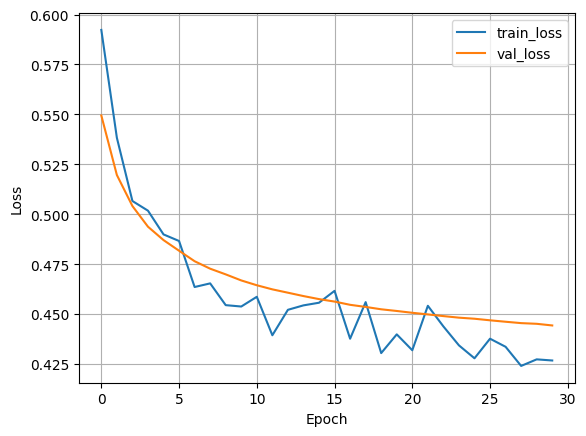

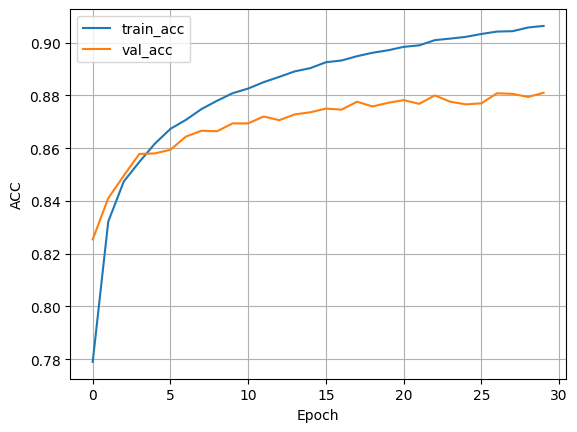

In [30]:
from local_utilities import plot_csv_logger
plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")